In [1]:
!pip install pandas numpy matplotlib scikit-learn 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import re 


review_dataset = pd.read_csv(r'../data/raw/imdb_dataset/imdb_master.csv',encoding='utf-8')

In [2]:
review_dataset.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


<p>We will drop the Unnamed:0 and the file columns because we don't need them </p>

In [3]:
review_dataset = review_dataset.drop(columns=['Unnamed: 0', 'file']).reset_index(drop=True)

<h2>Null & Duplicates values check</h2>

In [4]:
for col in review_dataset.columns:
    print(f"Column: {col}, Missing values: {review_dataset[col].isnull().sum()}")

Column: type, Missing values: 0
Column: review, Missing values: 0
Column: label, Missing values: 0


In [5]:
print(review_dataset['label'].value_counts())
print()
print(review_dataset['type'].value_counts())

label
unsup    50000
neg      25000
pos      25000
Name: count, dtype: int64

type
train    75000
test     25000
Name: count, dtype: int64


<p>Because the label and type columns are categorical data that we will need so will check only the column('review') for duplicates</p>

In [6]:
review_dataset['review'].duplicated().sum().item()

1531

In [7]:
review_dataset.loc[review_dataset['review'].duplicated(),'review']

1191     What a shocker. For starters, I couldn't stand...
1406     I see that C. Thomas Howell has appeared in ma...
1407     I see that C. Thomas Howell has appeared in ma...
1841     This movie looked like it was rushed to releas...
1974     I kind of like JAG. It do have it´s charm but ...
                               ...                        
99736    This movie, one of the best I've ever seen, ta...
99737    It's less visceral than the only other Tsai fi...
99738    (the description of the mood of the movie may ...
99739    *MINOR SPOILERS*<br /><br />Need any further p...
99740    In the final days of the year 1999, most every...
Name: review, Length: 1531, dtype: object

<p>we will check how many times each review appears</p>

In [8]:
review_counts = review_dataset['review'].value_counts()
duplicate_reviews = review_counts[review_counts > 1]
print(f"Number of unique reviews that have duplicate: {len(duplicate_reviews)}")

Number of unique reviews that have duplicate: 1471


In [9]:
print(duplicate_reviews.value_counts())

count
2    1424
3      40
5       4
4       2
6       1
Name: count, dtype: int64


In [10]:
print('Percentage of duplicate reviews: {:.2f}%'.format((review_dataset['review'].duplicated().sum().item() / len(review_dataset)) * 100))

Percentage of duplicate reviews: 1.53%


<strong>Because it is only 1.53% we will drop those values and check again the how many test and train data we have</strong>

In [11]:
print("Label Percentage distribution:\n", review_dataset['type'].value_counts(normalize=True) * 100)

Label Percentage distribution:
 type
train    75.0
test     25.0
Name: proportion, dtype: float64


In [12]:
review_dataset = review_dataset.drop_duplicates(subset=['review'],keep='first').reset_index(drop=True)

In [13]:
print("Length of dataset after removing duplicates: ", len(review_dataset))

Length of dataset after removing duplicates:  98469


<h2>Type and Label Distribution</h2>

In [14]:
type_counts = review_dataset['type'].value_counts(normalize=True)*100
label_counts = review_dataset['label'].value_counts(normalize=True)*100

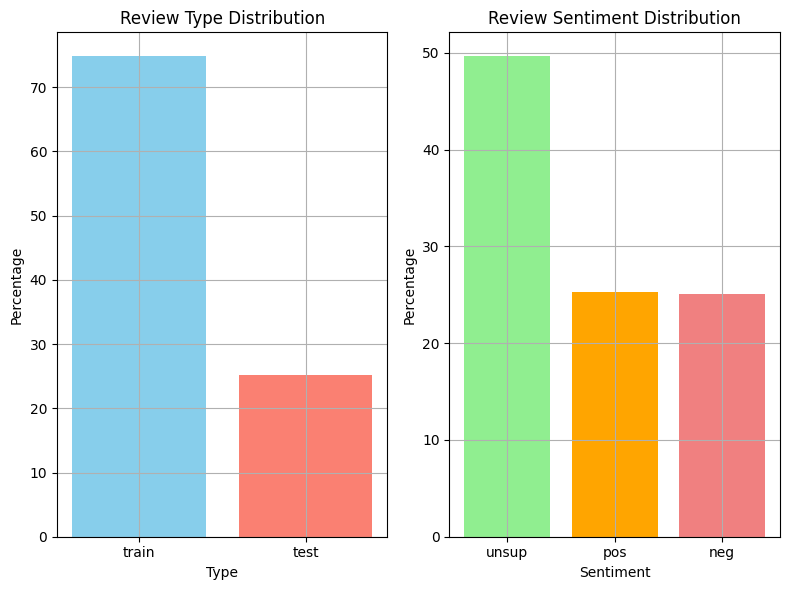

In [15]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.bar(type_counts.index,type_counts.values, color=['skyblue', 'salmon'])
plt.title('Review Type Distribution')
plt.xlabel('Type')
plt.ylabel('Percentage')
plt.grid(True)
plt.subplot(1,2,2)
plt.bar(label_counts.index,label_counts.values, color=['lightgreen', 'orange', 'lightcoral'])
plt.title('Review Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()


<strong>Later we will split the training with the test data</strong></br>
<ul>
    <li>Training Set: ~75%</li>
    <li>Test Set: ~25%</li>
</ul>
<strong>It can be observed that a high percentage of  reviews where mostly unsupported (not positive, not negative)</strong>

<h2>Text Length Analysis</h2>

<p>we will check the length and number of words distribution</p>

In [16]:
length_of_reviews = review_dataset['review'].apply(len)
num_words_in_reviews = review_dataset['review'].apply(lambda x: len(x.split()))

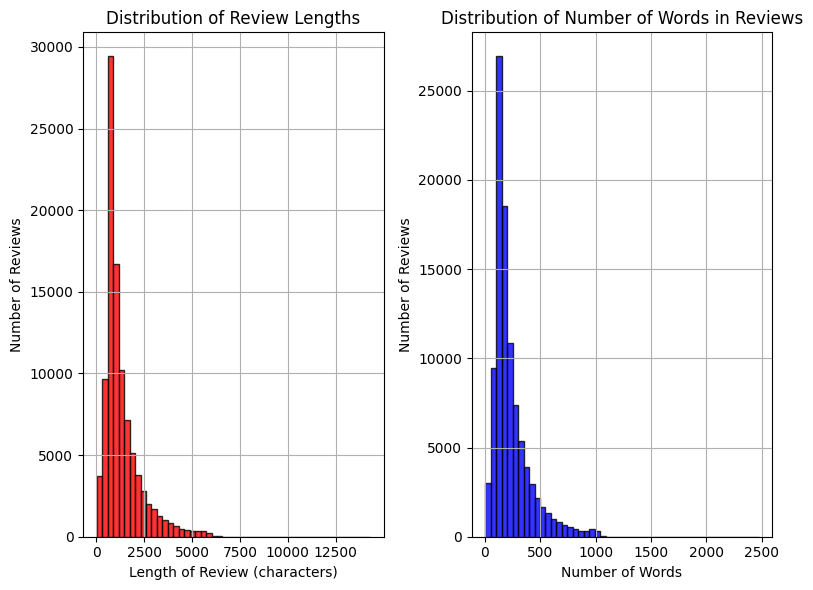

In [17]:

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.hist(length_of_reviews,bins=50,edgecolor='black',color='red',alpha=0.8)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review (characters)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.subplot(1,2,2)
plt.hist(num_words_in_reviews,bins=50,edgecolor='black',color='blue',alpha=0.8)
plt.title('Distribution of Number of Words in Reviews')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()


<p>From the plots we can see that we might have some outliers in the words or length of the reviews, but in general aspect most reviews remain consistend and friendly rage</p><br/>
<strong>So we are going to do an outlier inspection</strong>

<h2>Outlier Detection</h2>

/var/folders/lw/fl7prrw1671044k3vst005600000gq/T/ipykernel_35252/2305273577.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([length_of_reviews,num_words_in_reviews],labels=['Length of Reviews','Number of Words'])


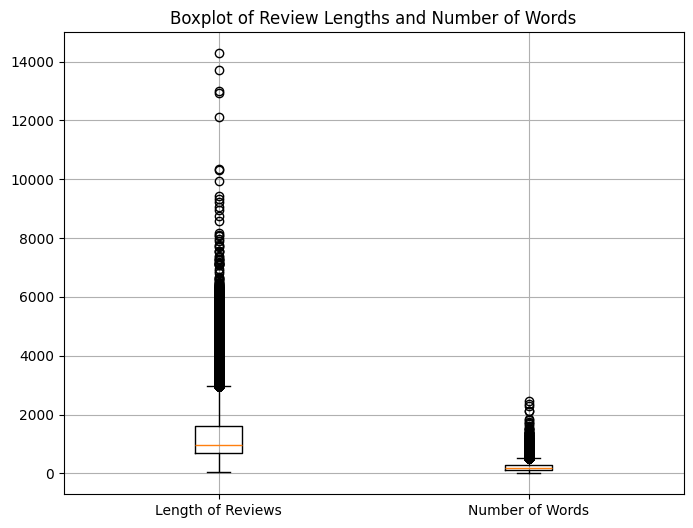

In [18]:
plt.figure(figsize=(8,6))
plt.boxplot([length_of_reviews,num_words_in_reviews],labels=['Length of Reviews','Number of Words'])
plt.title('Boxplot of Review Lengths and Number of Words')
plt.grid(True)
plt.show()


<p>so we will check the lower_bound and higher_bound of those variables:

$$lower\_bound = Q1 - 1.5 \times IQR$$

$$higher\_bound = Q3 + 1.5 \times IQR$$

In [23]:
Q1_LENGTH=  length_of_reviews.quantile(0.25)
Q3_LENGTH=  length_of_reviews.quantile(0.75)
IQR_LENGTH = Q3_LENGTH - Q1_LENGTH
lower_bound_length = Q1_LENGTH - 1.5 * IQR_LENGTH
upper_bound_length = Q3_LENGTH + 1.5 * IQR_LENGTH
print(f"Range of reviews: [{lower_bound_length if lower_bound_length >= 0 else 0},{upper_bound_length}]")
print(f"Number of outliers in review lengths: {length_of_reviews[(length_of_reviews < lower_bound_length) | (length_of_reviews > upper_bound_length)].count()}")
print("Percentage of outliers in review lengths: {:.2f}%".format((length_of_reviews[(length_of_reviews < lower_bound_length) | (length_of_reviews > upper_bound_length)].count() / len(review_dataset)) * 100))


Range of reviews: [0,2964.5]
Number of outliers in review lengths: 7322
Percentage of outliers in review lengths: 7.44%


In [25]:
Q1_WORDS = num_words_in_reviews.quantile(0.25)
Q3_WORDS = num_words_in_reviews.quantile(0.75)
IQR_WORDS = Q3_WORDS - Q1_WORDS
lower_bound_words = Q1_WORDS - 1.5 * IQR_WORDS
upper_bound_words = Q3_WORDS + 1.5 * IQR_WORDS
print(f"Range of number of words: [{lower_bound_words if lower_bound_words >= 0 else 0},{upper_bound_words}]")
print(f"Number of outliers in review words: {num_words_in_reviews[(num_words_in_reviews<lower_bound_words) | (num_words_in_reviews>upper_bound_words)].count()}")
print("Percentage of outliers in review words:: {:.2f}%".format(num_words_in_reviews[(num_words_in_reviews < lower_bound_words) | (num_words_in_reviews> upper_bound_words)].count()/ len(review_dataset) * 100))

Range of number of words: [0,517.0]
Number of outliers in review words: 7273
Percentage of outliers in review words:: 7.39%


In [19]:
print("Statistical Summary of Review Lengths:")
print(length_of_reviews.describe())
print("\nStatistical Summary of Number of Words in Reviews:")
print(num_words_in_reviews.describe())


Statistical Summary of Review Lengths:
count    98469.000000
mean      1321.575582
std        999.194416
min         32.000000
25%        702.000000
50%        978.000000
75%       1607.000000
max      14282.000000
Name: review, dtype: float64

Statistical Summary of Number of Words in Reviews:
count    98469.000000
mean       233.085225
std        172.851577
min          4.000000
25%        127.000000
50%        174.000000
75%        283.000000
max       2470.000000
Name: review, dtype: float64


<h2>Split and Preprocess Data</h2>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score as accuracy, precision_score as precision, recall_score as recall , f1_score as f1 
from sklearn.svm import SVC 


<h2>Training of Model</h2>

<h2>Evaluation</h2>